# 성능개선 기법 실습 개요

1. 각 모듈을 정의            
    (1) 모델 학습,검증    
    (2) dataset 생성               
    (3) 학습결과 시각화 함수
2. 모델링을 하기 위한 실습 세팅         
    (1)Import          
    (2)하이퍼파라미터/변수 정의      
    (3)데이터 로딩
3. 모델 성능개선에 영향을 미치는 아래의 요소에 대한 모델링을 진행하며, 하나하나 결과를 확인합니다.
    - 큰모델 vs 작은모델
    - Dropout
    - Batch normalization
    - Learning rate

# 모듈 정의


## train.py

-   모델 학습과 검증 함수 정의


In [31]:
import os

os.makedirs("module", exist_ok=True)

In [ ]:
%%writefile module/train.py

import torch
import time

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    Args:
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    Returns:
        tuple: (loss, accuracy)
    """
    model.to(device)                    # 모델을 지정된 장치(cpu/gpu)로 이동
    model.eval()                        # 평가 모드로 설정 (dropout 등 비활성화)
    size = len(dataloader.dataset)      # 전체 데이터 수
    num_steps = len(dataloader)         # 배치 수

    test_loss, test_accuracy = 0., 0.   # 초기화
    
    with torch.no_grad():               # 그래디언트 계산 비활성화
        for X, y in dataloader:         # 배치 단위 반복
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            ## 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)    # 예측 클래스
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_steps          # 평균 loss
        test_accuracy /= size           # 전체 대비 정확도

    return test_loss, test_accuracy     # 튜플 반환

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    >>>> 다중분류와 거의 동일하되, 정확도 계산방식만 다름
    
    Args:
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    Returns:
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval()                    # 평가 모드로 설정 (dropout 등 비활성화)
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)  # 0.5 이상이면 1로 분류
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_steps
        test_accuracy /= size      #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    Args:
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi 
    
    Returns:
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()                           # 학습 모드로 전환
    size = len(dataloader.dataset)          # 전체 학습 데이터 수(총 데이터포인트 개수)

    for X, y in dataloader:                 # 배치 단위 반복
        X, y = X.to(device), y.to(device)   # 1. DEVICE로 이동.
        pred = model(X)                     # 2. forward(모델 추정)
        loss = loss_fn(pred, y)             # 3. loss 계산
        optimizer.zero_grad()               # 4. 기존 gradient 초기화
        loss.backward()                     # 5. 역전파로 gradient 계산
        optimizer.step()                    # 6. 파라미터 업데이트
        
    # 학습이 끝난 후에 동일 train 데이터를 평가    
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, 
        save_model_path=None, early_stopping=True, patience=10, device='cpu',  mode:"binary or multi"='binary',
        lr_scheduler=None):
    """
    모델을 학습시키는 함수
    >>>>> 전체 학습 루프(Epoch 단위)

    Args:
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
        lr_scheduler: Learning Rate Scheduler 객체. default: None, Epoch 단위로 LR 를 변경.
    
    Returns:
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []                # 결과 저장용 리스트
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf     # 최고 성능 저장 초기값

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf       # early stopping 기준 점수
    
    # 모델 device로 옮기기
    model = model.to(device)          # 모델 장치로 이동
    s = time.time()                   # 시간 측정 시작

    for epoch in range(epochs):       # 에폭 반복
        # 1 epoch 학습
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)

        ############ 1 epoch 학습 종료 후-> LR를 조정 (있으면) ########### 
        if lr_scheduler is not None: 
            current_lr = lr_scheduler.get_last_lr()[0]  # log용
            lr_scheduler.step()   ###### lr_scheduler.step(step) 이렇게 두면 step 단위로 lr을 변경한다.
            new_lr = lr_scheduler.get_last_lr()[0] # log용
            if current_lr != new_lr: # LR가 변경되었으면
                print(f">>>>>>Learning Rate가 {current_lr}에서 {new_lr}로 변경됨<<<<<<")
    

        # 검증 데이터셋 평가
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        # 에폭별 결과 저장 및 출력
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 가장 좋은 모델 저장
        if save_best_model:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # Early Stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

def train_caws(dataloader, model, loss_fn, optimizer, device="cpu", mode:'binary or multi'='binary', lr_scheduler=None, epoch=None):
    model.train()
    size = len(dataloader.dataset)
    steps_per_epoch = len(dataloader)

    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 🎯 scheduler를 step 단위로 호출
        if lr_scheduler is not None and epoch is not None:
            fractional_epoch = epoch + batch_idx / steps_per_epoch
            lr_scheduler.step(fractional_epoch)

    # 평가
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy


def fit_caws(train_loader, val_loader, model, loss_fn, optimizer, epochs,
             save_best_model=True, save_model_path=None, early_stopping=True,
             patience=10, device='cpu', mode="binary", lr_scheduler=None):
    """
    CosineAnnealingWarmRestarts를 step 단위로 적용하는 학습 루틴.
    train_caws()를 내부에서 사용하며, scheduler.step(fractional_epoch)를 step마다 호출함.
    """
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []

    if save_best_model:
        best_score_save = torch.inf

    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf

    model = model.to(device)
    import time
    s = time.time()

    for epoch in range(epochs):
        # 🔁 CosineAnnealingWarmRestarts를 step 단위로 적용하는 train_caws() 호출
        train_loss, train_accuracy = train_caws(
            train_loader, model, loss_fn, optimizer,
            device=device, mode=mode,
            lr_scheduler=lr_scheduler, epoch=epoch
        )

        # ✅ scheduler.step() 호출 제거됨

        # 검증
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        # 로그 및 저장
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)

        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Acc: {train_accuracy:.5f} || Val loss: {val_loss:.5f} Val Acc: {val_accuracy:.5f}")
        print('='*100)

        if save_best_model and val_loss < best_score_save:
            torch.save(model, save_model_path)
            print(f"저장: {epoch+1} - 이전: {best_score_save:.5f}, 현재: {val_loss:.5f}")
            best_score_save = val_loss

        if early_stopping:
            if val_loss < best_score_es:
                best_score_es = val_loss
                trigger_count = 0
            else:
                trigger_count += 1
                if trigger_count >= patience:
                    print(f"Early stopping: Epoch - {epoch}")
                    break

    e = time.time()
    print(e - s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list



Overwriting module/train.py


## data.py

-   dataset 생성 함수 제공 모듈


In [ ]:
%%writefile module/data.py

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    Args:
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    
    Returns:
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    Args:
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    
    Returns:
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader




Overwriting module/data.py


## utils.py


In [34]:
%%writefile module/utils.py
# 학습 결과를 시각화하는 함수.
import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list):
    """epoch별 학습 결과를 시각화하는 함수
    epoch별 loss와 accuracy를 시각화한다.

    Args:
        train_loss_list (list): Epoch별 train loss
        train_accuracy_list (list): Epoch별 train accuracy
        valid_loss_list (list): Epoch별 validation loss
        valid_accuracy_list (list): Epoch별 validation accuracy
    """
    epoch = len(train_loss_list)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch), train_loss_list, label="train loss")
    plt.plot(range(epoch), valid_loss_list, label="validation loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epoch), train_accuracy_list, label="train accuracy")
    plt.plot(range(epoch), valid_accuracy_list, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

Overwriting module/utils.py


## Import

In [35]:
import torch
import torch.nn as nn
from torchinfo import summary

from module.train import fit
from module.data import load_mnist_dataset, load_fashion_mnist_dataset
from module.utils import plot_fit_result

## 하이퍼파라미터, 변수 정의


In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
root_data_path = "datasets"

epochs = 100
batch_size = 256
lr = 0.001

# Data 준비

## mnist 데이터 로딩


In [37]:
train_loader = load_mnist_dataset(root_data_path, batch_size)
test_loader = load_mnist_dataset(root_data_path, batch_size, False)

## Fashion Mnist
# train_loader = load_fashion_mnist_dataset(root_data_path, batch_size)
# test_loader = load_fashion_mnist_dataset(root_data_path, batch_size, False)

In [38]:
classes = train_loader.dataset.classes
class_to_idx = train_loader.dataset.class_to_idx

In [39]:
classes
class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

# 모델의 크기 변경에 따른 성능변화
## 작은 모델

In [40]:
class SmallModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lr = nn.Linear(28*28, 10) # 입력 -> 출력 / 손글씨 이미지 픽셀 28*28 = 784 픽셀

    def forward(self, X):
        X = nn.Flatten()(X)
        out = self.lr(X)
        return out

In [41]:
small_model = SmallModel().to(device)
summary(small_model, (100, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
SmallModel                               [100, 10]                 --
├─Linear: 1-1                            [100, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.79
Input size (MB): 0.31
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.35

In [42]:
loss_fn = nn.CrossEntropyLoss() # 다중분류의 loss함수
optimizer = torch.optim.Adam(small_model.parameters(), lr=lr)

In [43]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader,
    test_loader,
    small_model,
    loss_fn,
    optimizer,
    epochs,
    save_best_model=False,
    patience=5,
    device=device,
    mode='multi'
)
# 에폭설정(patience=5,)을 안해서, 오래걸려서 중간에 끊음


Epoch[1/100] - Train loss: 0.48716 Train Accucracy: 0.87810 || Validation Loss: 0.46455 Validation Accuracy: 0.88830
Epoch[2/100] - Train loss: 0.38061 Train Accucracy: 0.89967 || Validation Loss: 0.36273 Validation Accuracy: 0.90370
Epoch[3/100] - Train loss: 0.34036 Train Accucracy: 0.90895 || Validation Loss: 0.32546 Validation Accuracy: 0.90950
Epoch[4/100] - Train loss: 0.31754 Train Accucracy: 0.91395 || Validation Loss: 0.30472 Validation Accuracy: 0.91490
Epoch[5/100] - Train loss: 0.30309 Train Accucracy: 0.91698 || Validation Loss: 0.29185 Validation Accuracy: 0.91840
Epoch[6/100] - Train loss: 0.29280 Train Accucracy: 0.91993 || Validation Loss: 0.28450 Validation Accuracy: 0.92100
Epoch[7/100] - Train loss: 0.28487 Train Accucracy: 0.92087 || Validation Loss: 0.27807 Validation Accuracy: 0.92110
Epoch[8/100] - Train loss: 0.28036 Train Accucracy: 0.92258 || Validation Loss: 0.27539 Validation Accuracy: 0.92240
Epoch[9/100] - Train loss: 0.27485 Train Accucracy: 0.92363 || V

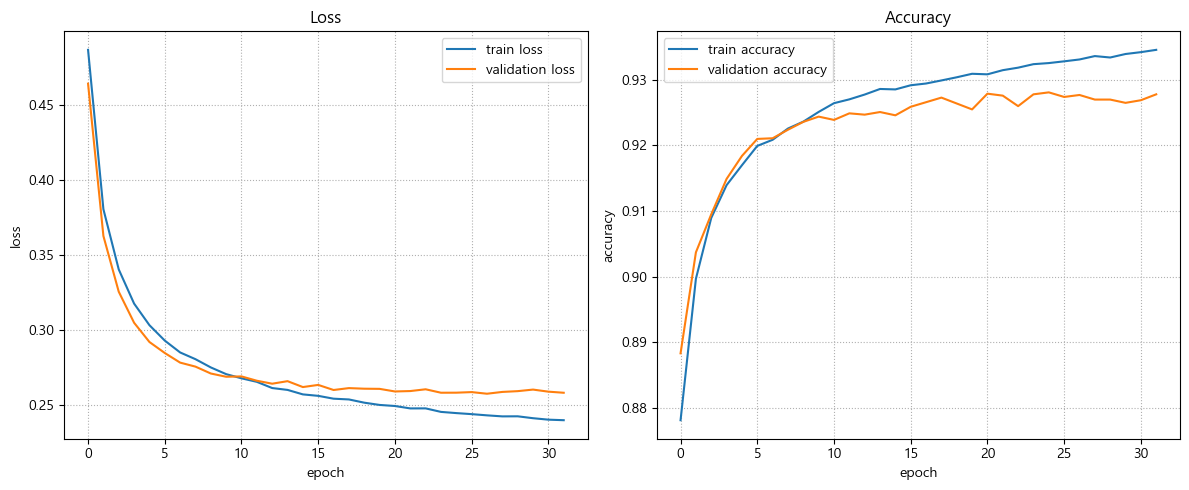

In [44]:
# 작은모델 plot
plot_fit_result(
    train_loss_list, train_acc_list, valid_loss_list, valid_acc_list
)

In [45]:
###### nn.Sequential() -> layer block: 레이어함수들을 묶어 놓은 블록
###### 간단한 다층 퍼셉트론(MLP) 블록을 만들기: 입력차원이 10, 출력 차원이 30
s = nn.Sequential(
    nn.Linear(10,20),
    nn.ReLU(),
    nn.Linear(20,30),
    nn.ReLU()
)
i = torch.randn(5, 10, dtype=torch.float32)
o = s(i)
print(o.shape)
o #>>> 0.000으로 나오는 것들은 음수였는데 ReLU에 의해 0으로 된 것9

torch.Size([5, 30])


tensor([[0.0000, 0.5018, 0.0000, 0.0000, 0.0000, 0.0306, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1126, 0.5141, 0.0000, 0.4699, 0.2729, 0.3790, 0.5549, 0.1082,
         0.1315, 0.0000, 0.0751, 0.4080, 0.1818, 0.0000, 0.5311, 0.1416, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0583, 0.3738, 0.0000, 0.4359, 0.0000, 0.2103, 0.4016, 0.0286, 0.0000,
         0.2334, 0.1623, 0.0000, 0.0000, 0.0000, 0.3902, 0.2609, 0.1332, 0.0000,
         0.0000, 0.0000, 0.0768, 0.0000, 0.6093, 0.0000, 0.0000, 0.0000, 0.0000,
         0.2565, 0.0055, 0.0130],
        [0.0000, 0.3150, 0.0000, 0.1761, 0.0402, 0.0000, 0.3123, 0.0000, 0.0000,
         0.1153, 0.0310, 0.5306, 0.0000, 0.2554, 0.0000, 0.0000, 0.0000, 0.1678,
         0.0000, 0.0000, 0.1694, 0.0000, 0.3418, 0.0000, 0.4176, 0.1650, 0.0000,
         0.1140, 0.1882, 0.0000],
        [0.0000, 0.7097, 0.0000, 0.0136, 0.0000, 0.1740, 0.1148, 0.0000, 0.0000,
         0.0000, 0.1521, 0.3142, 0.0000, 0.4379, 0.1235, 0.9152, 0.5636, 0.0977,
       

## 큰모델

In [46]:
class BigModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.ReLU())
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.out_block = nn.Linear(32,10)

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        return self.out_block(X)

In [47]:
big_model = BigModel().to(device)
summary(big_model, (100,1,28,28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
BigModel                                 [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 2048]               1,607,680
│    └─ReLU: 2-3                         [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-4                       [100, 1024]               2,098,176
│    └─ReLU: 2-5                         [100, 1024]               --
├─Sequential: 1-3                        [100, 512]                --
│    └─Linear: 2-6                       [100, 512]                524,800
│    └─ReLU: 2-7                         [100, 512]                --
├─Sequential: 1-4                        [100, 256]                --
│    └─Linear: 2-8                       [100, 256]               

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=lr)

In [49]:
train_loss_list2, train_acc_list2, valid_loss_list2, valid_acc_list2 = fit(
    train_loader, test_loader,
    big_model,
    loss_fn,
    optimizer,
    epochs,
    save_best_model=False,
    patience=5,
    device=device,
    mode='multi'
)

Epoch[1/100] - Train loss: 0.18269 Train Accucracy: 0.94702 || Validation Loss: 0.19195 Validation Accuracy: 0.94190
Epoch[2/100] - Train loss: 0.10194 Train Accucracy: 0.97167 || Validation Loss: 0.12860 Validation Accuracy: 0.96330
Epoch[3/100] - Train loss: 0.06759 Train Accucracy: 0.98027 || Validation Loss: 0.10327 Validation Accuracy: 0.97010
Epoch[4/100] - Train loss: 0.04701 Train Accucracy: 0.98677 || Validation Loss: 0.08503 Validation Accuracy: 0.97690
Epoch[5/100] - Train loss: 0.03897 Train Accucracy: 0.98888 || Validation Loss: 0.08727 Validation Accuracy: 0.97680
Epoch[6/100] - Train loss: 0.02143 Train Accucracy: 0.99380 || Validation Loss: 0.07563 Validation Accuracy: 0.97940
Epoch[7/100] - Train loss: 0.03422 Train Accucracy: 0.98982 || Validation Loss: 0.09514 Validation Accuracy: 0.97640
Epoch[8/100] - Train loss: 0.01982 Train Accucracy: 0.99398 || Validation Loss: 0.08128 Validation Accuracy: 0.97900
Epoch[9/100] - Train loss: 0.01183 Train Accucracy: 0.99655 || V

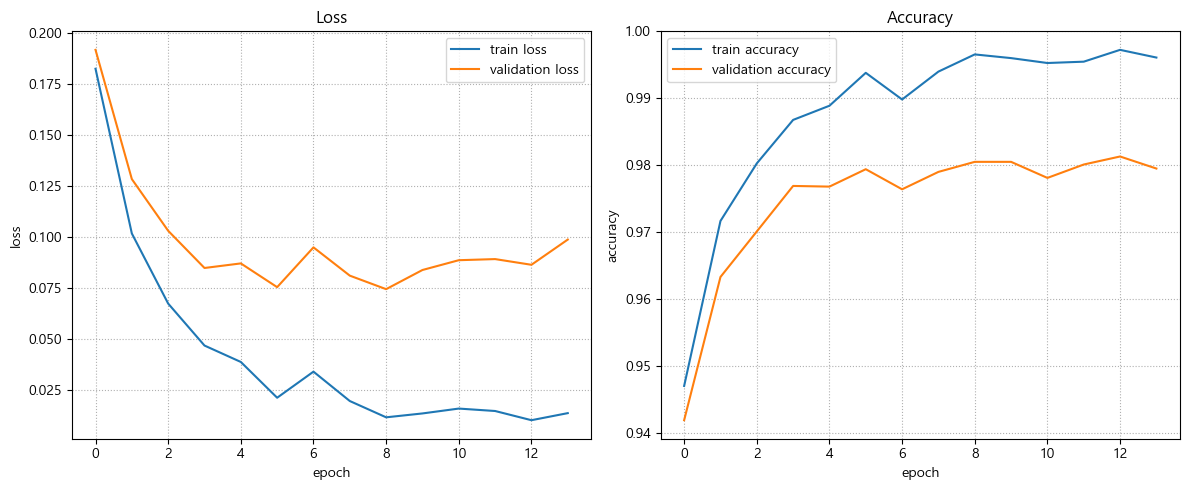

In [50]:
# 큰모델 plot
plot_fit_result(
    train_loss_list2, train_acc_list2, valid_loss_list2, valid_acc_list2
)

#### 결: MNIST 데이터는 **딥러닝 기준에서 보면 "작은 편"**에 속합니다.

# Dropout 예제

-   dropout 각 레이어에 적용
    -   dropout은 nn.Dropout 객체를 사용
    -   객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    -   Drop시킬 노드를 가진 Layer 뒤에 추가한다.


In [51]:
class DropoutModel(nn.Module):

    def __init__(self, drop_rate=0.2):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.out_block = nn.Linear(32,10)

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        return self.out_block(X)
    

In [52]:
dout_model = DropoutModel(drop_rate=0.5).to(device)
summary(dout_model, (100,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
DropoutModel                             [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 2048]               1,607,680
│    └─ReLU: 2-3                         [100, 2048]               --
│    └─Dropout: 2-4                      [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-5                       [100, 1024]               2,098,176
│    └─ReLU: 2-6                         [100, 1024]               --
│    └─Dropout: 2-7                      [100, 1024]               --
├─Sequential: 1-3                        [100, 512]                --
│    └─Linear: 2-8                       [100, 512]                524,800
│    └─ReLU: 2-9                         [100, 512]               

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dout_model.parameters(), lr=lr)

In [54]:
train_loss_list3, train_acc_list3, valid_loss_list3, valid_acc_list3 = fit(
    train_loader, test_loader,
    dout_model,
    loss_fn,
    optimizer,
    epochs,
    save_best_model=False,
    patience=5,
    device=device,
    mode='multi'
)

Epoch[1/100] - Train loss: 0.75796 Train Accucracy: 0.67795 || Validation Loss: 0.75186 Validation Accuracy: 0.68330
Epoch[2/100] - Train loss: 0.48149 Train Accucracy: 0.77887 || Validation Loss: 0.50000 Validation Accuracy: 0.77740
Epoch[3/100] - Train loss: 0.37197 Train Accucracy: 0.86263 || Validation Loss: 0.38727 Validation Accuracy: 0.86070
Epoch[4/100] - Train loss: 0.30454 Train Accucracy: 0.91783 || Validation Loss: 0.32573 Validation Accuracy: 0.91790
Epoch[5/100] - Train loss: 0.27087 Train Accucracy: 0.94755 || Validation Loss: 0.30967 Validation Accuracy: 0.94590
Epoch[6/100] - Train loss: 0.23316 Train Accucracy: 0.95885 || Validation Loss: 0.27572 Validation Accuracy: 0.95270
Epoch[7/100] - Train loss: 0.19644 Train Accucracy: 0.96550 || Validation Loss: 0.25678 Validation Accuracy: 0.95810
Epoch[8/100] - Train loss: 0.20800 Train Accucracy: 0.95508 || Validation Loss: 0.25863 Validation Accuracy: 0.95100
Epoch[9/100] - Train loss: 0.17371 Train Accucracy: 0.96533 || V

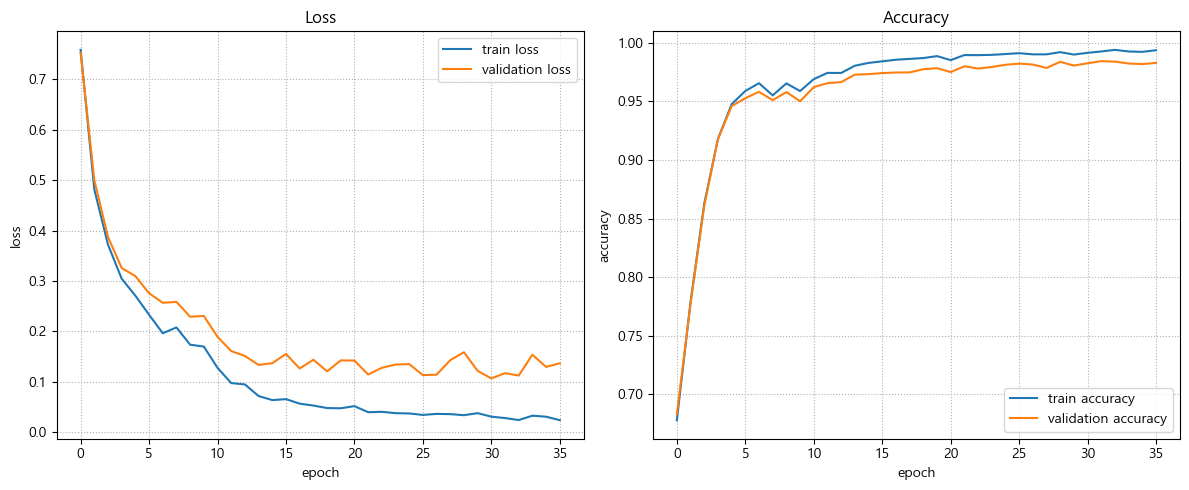

In [55]:
# Dropout plot
plot_fit_result(
    train_loss_list3, train_acc_list3, valid_loss_list3, valid_acc_list3
)

# Batch Normalization

- Dense 와 Activation 사이에 정의한다.


In [56]:
# nn.BatchNorm1d(입력 feature개수)
# Lenear -> BatchNorm -> ReLU(Activation)
# Lenear -> BatchNorm -> ReLU(Activation) -> Dropout

class BatchNormModel(nn.Module):

    def __init__(self, drop_rate=0.2):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.BatchNorm1d(2048), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.out_block = nn.Linear(32,10)

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        return self.out_block(X)

In [57]:
bn_model = BatchNormModel(drop_rate=0.5).to(device)
summary(bn_model, (100,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
BatchNormModel                           [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 2048]               1,607,680
│    └─BatchNorm1d: 2-3                  [100, 2048]               4,096
│    └─ReLU: 2-4                         [100, 2048]               --
│    └─Dropout: 2-5                      [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-6                       [100, 1024]               2,098,176
│    └─BatchNorm1d: 2-7                  [100, 1024]               2,048
│    └─ReLU: 2-8                         [100, 1024]               --
│    └─Dropout: 2-9                      [100, 1024]               --
├─Sequential: 1-3                        [100, 512]              

In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bn_model.parameters(), lr=lr)

train_loss_list4, train_acc_list4, valid_loss_list4, valid_acc_list4 = fit(
    train_loader, test_loader,
    bn_model,
    loss_fn,
    optimizer,
    epochs,
    save_best_model=False,
    patience=5,
    device=device,
    mode="multi"
)

Epoch[1/100] - Train loss: 0.50977 Train Accucracy: 0.78453 || Validation Loss: 0.51034 Validation Accuracy: 0.78560
Epoch[2/100] - Train loss: 0.39015 Train Accucracy: 0.80232 || Validation Loss: 0.40154 Validation Accuracy: 0.79590
Epoch[3/100] - Train loss: 0.27728 Train Accucracy: 0.87927 || Validation Loss: 0.28993 Validation Accuracy: 0.88020
Epoch[4/100] - Train loss: 0.23765 Train Accucracy: 0.88695 || Validation Loss: 0.25264 Validation Accuracy: 0.88540
Epoch[5/100] - Train loss: 0.22284 Train Accucracy: 0.89028 || Validation Loss: 0.24564 Validation Accuracy: 0.88730
Epoch[6/100] - Train loss: 0.21143 Train Accucracy: 0.89543 || Validation Loss: 0.23212 Validation Accuracy: 0.89210
Epoch[7/100] - Train loss: 0.17702 Train Accucracy: 0.95373 || Validation Loss: 0.20544 Validation Accuracy: 0.94980
Epoch[8/100] - Train loss: 0.07953 Train Accucracy: 0.98105 || Validation Loss: 0.11156 Validation Accuracy: 0.97470
Epoch[9/100] - Train loss: 0.06736 Train Accucracy: 0.98380 || V

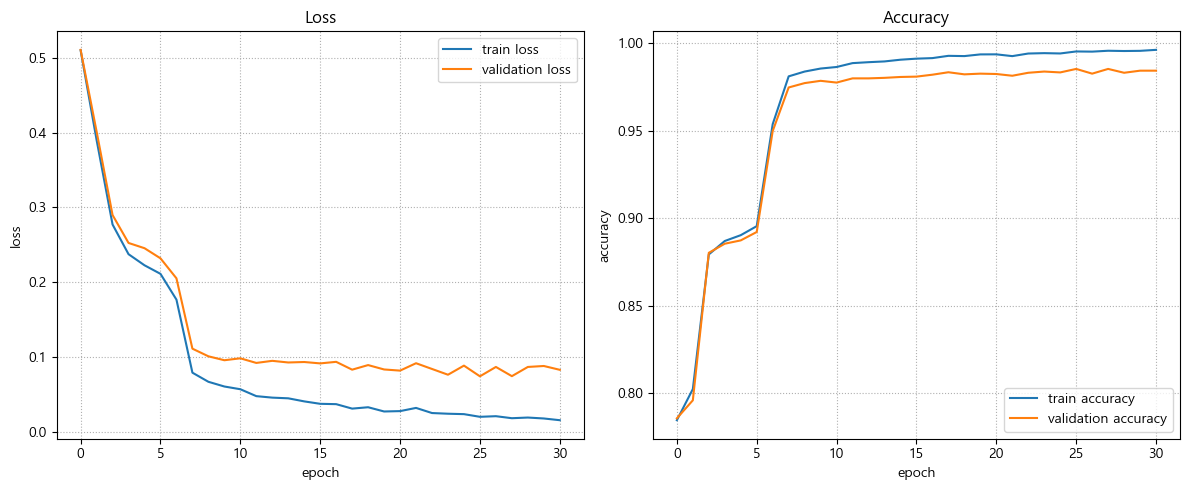

In [59]:
# batch normalization plot
plot_fit_result(
    train_loss_list4, train_acc_list4, valid_loss_list4, valid_acc_list4
)

# Learning rate decay


### Optimizer와 Learning rate scheduler의 속성, 메소드 확인

-   파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.


In [60]:
import matplotlib.pyplot as plt

def plot_lr(title, lr_list):
    """Learning 스케쥴러(학습도중 LR를 변경시키는 객체.)에 의해 변화되는 Learning Rate값을 시각화.

    Args:
        title (str): title
        lr_list (list): Learning Rate 스케쥴러에 의해 변경된 learning rate값들을 가지는 list
    """
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(lr_list)), lr_list)

    plt.title(title)
    xticks = [x for x in range(len(lr_list)) if x % 10 == 0] # 눈금을 10 배수 자리에 위치.
    plt.xticks(xticks)
    plt.xlabel("Epoch 수 또는 Step 수")
    plt.ylabel("학습률-LR")
    plt.grid(True, linestyle=":")
    plt.show()

#### StepLR


In [61]:
# step을 진행하다가 내가 지정한 step에 도달하면 특정 비율로 LR을 줄이고 진행하고, 그 다음 지정 step이 되면 LR을 줄이고 진행하는 방식으로 진행.(계단식)
SBModel = SmallModel()
optim = torch.optim.Adam(SBModel.parameters(),lr=0.001)

# optimizer에서 현재 LR을 조회
optim.param_groups[0]["lr"]

0.001

In [62]:
# LearningRate Scheduler - StepLR - 계단 형태로 LR을 특정 step마다 특정 비율로 줄여나간다.
# 아래는 30step마다 LR을 '현재학습률'을 0.5배하며 변경
steplr_scheduler = torch.optim.lr_scheduler.StepLR(
    optim, # 학습률을 변경할 optimizer
    step_size = 30, # 몇 step마다 Learning을 변경할지. >>> 구현하기 따라 epoch으로 넣을 수 있다. >> 지금은 lr_scheduler.step(): 이것이 30번 실행되면 LR*gamma로 변경
    gamma =0.5 # 변경할 비율.
)

# 현재 LR을 스케쥴러로부터 조회
steplr_scheduler.get_last_lr()

[0.001]

In [63]:
# 통상의 순서
## 모델 생성
## Loss 함수 생성
## optimizer 생성
## LR scheduer 생성

# 학습
epochs = 300
step_size = 10 # len(dataloader)와 같은 값
lr_list =[]

for epoch in range(epochs):

    for step in range(step_size): # for x,y in dataloader 의 역할과 같다.
        # 1 step 학습
        # x,y device로 이동
        # 추론 >> p = model(x)
        # loss. loss = loss_fn(p,y)
        # grad. loss.backward()
        optim.step() # update 작업
        optim.zero_grad() # grad 초기화

        steplr_scheduler.step() # LR를 변경 요청.
        lr_list.append(steplr_scheduler.get_last_lr()) # step()후 lr을 list에 저장

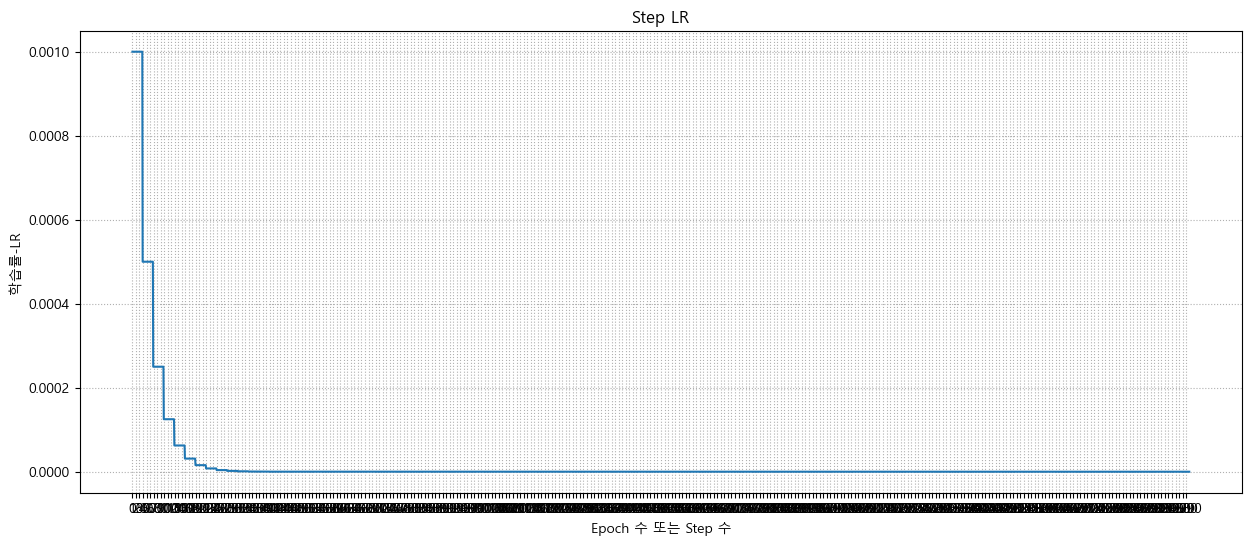

In [64]:
plt.rcParams['font.family'] = 'malgun gothic'
plot_lr("Step LR", lr_list)

Epoch[1/100] - Train loss: 0.18748 Train Accucracy: 0.94693 || Validation Loss: 0.20756 Validation Accuracy: 0.94070
Epoch[2/100] - Train loss: 0.08816 Train Accucracy: 0.97513 || Validation Loss: 0.11068 Validation Accuracy: 0.96610
Epoch[3/100] - Train loss: 0.06321 Train Accucracy: 0.98163 || Validation Loss: 0.10060 Validation Accuracy: 0.97240
Epoch[4/100] - Train loss: 0.04721 Train Accucracy: 0.98620 || Validation Loss: 0.08695 Validation Accuracy: 0.97510
Epoch[5/100] - Train loss: 0.03772 Train Accucracy: 0.98975 || Validation Loss: 0.08680 Validation Accuracy: 0.97460
Epoch[6/100] - Train loss: 0.04004 Train Accucracy: 0.98868 || Validation Loss: 0.10036 Validation Accuracy: 0.97510
Epoch[7/100] - Train loss: 0.02900 Train Accucracy: 0.99133 || Validation Loss: 0.09033 Validation Accuracy: 0.97530
Epoch[8/100] - Train loss: 0.02905 Train Accucracy: 0.99138 || Validation Loss: 0.09905 Validation Accuracy: 0.97280
Epoch[9/100] - Train loss: 0.02448 Train Accucracy: 0.99295 || V

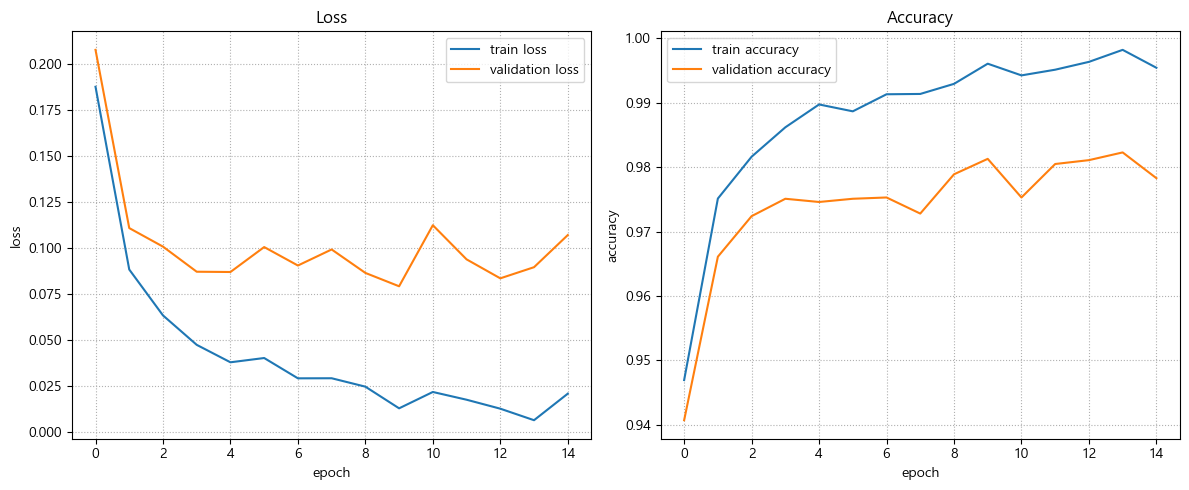

In [ ]:
# Step LR을 Big model에 적용시켜 시각화하기

import torch
import torch.nn as nn
from torchinfo import summary

from module.train import fit, train
from module.data import load_mnist_dataset
from module.utils import plot_fit_result

# ----------------------------
# 기본 설정
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
root_data_path = "datasets"
epochs = 100
batch_size = 256
lr = 0.001

# ----------------------------
# 데이터 로딩
# ----------------------------
train_loader = load_mnist_dataset(root_data_path, batch_size)
test_loader = load_mnist_dataset(root_data_path, batch_size, False)

# ----------------------------
# 모델 정의
# ----------------------------
class BigModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.ReLU())
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.out_block = nn.Linear(32,10)

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        return self.out_block(X)

# ----------------------------
# 학습 설정
# ----------------------------
big_model = BigModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=lr)

# StepLR: 30 epoch마다 LR을 절반으로 감소
steplr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=30,
    gamma=0.5
)

# ----------------------------
# 학습
# ----------------------------
train_loss_list5, train_acc_list5, valid_loss_list5, valid_acc_list5 = fit(
    train_loader,
    test_loader,
    big_model,
    loss_fn,
    optimizer,
    epochs,
    save_best_model=False,
    patience=5,
    device=device,
    mode='multi',
    lr_scheduler=steplr_scheduler
)

# ----------------------------
# 시각화
# ----------------------------
plot_fit_result(
    train_loss_list5,
    train_acc_list5,
    valid_loss_list5,
    valid_acc_list5
)


#### CosineAnnealingLR

cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.


In [66]:
optim = torch.optim.Adam(small_model.parameters(), lr = 0.001)
ca_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim,
    T_max=10, # 변화주기 step/epoch - 최댓값(초기 LR)에서 최솟값까지 가는데 10epoch, 최솟값에서 최댓값으로 가는데 10epoch
    eta_min=1e-6, #lr 최소값 지정
)

In [67]:
lr_list = []
for epoch in range(epochs):
    for step in range(step_size):
        # ... 학습
        optim.step()
        optim.zero_grad()

    ca_lr_scheduler.step() # epoch단위로 lr변경
    lr_list.append(ca_lr_scheduler.get_last_lr())
    

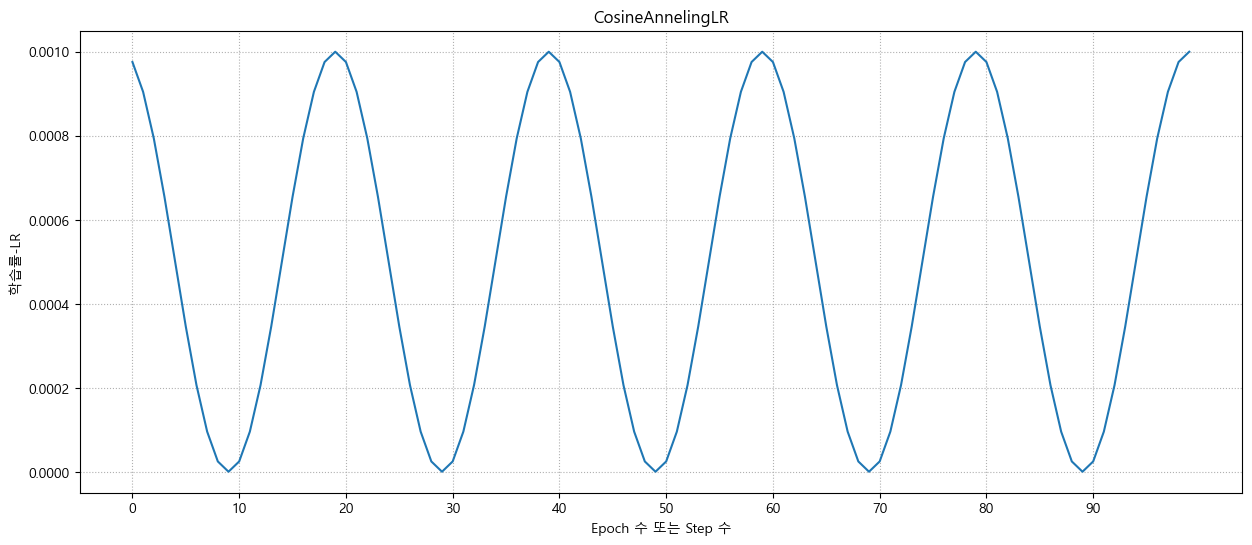

In [68]:
plot_lr("CosineAnnelingLR", lr_list)

>>>>>>Learning Rate가 0.001에서 0.0009755527298894294로 변경됨<<<<<<
Epoch[1/100] - Train loss: 0.15197 Train Accucracy: 0.95643 || Validation Loss: 0.16448 Validation Accuracy: 0.95250
>>>>>>Learning Rate가 0.0009755527298894294에서 0.0009046039886902864로 변경됨<<<<<<
Epoch[2/100] - Train loss: 0.08163 Train Accucracy: 0.97740 || Validation Loss: 0.10264 Validation Accuracy: 0.96940
>>>>>>Learning Rate가 0.0009046039886902864에서 0.0007940987335200905로 변경됨<<<<<<
Epoch[3/100] - Train loss: 0.06948 Train Accucracy: 0.97957 || Validation Loss: 0.11686 Validation Accuracy: 0.96770
>>>>>>Learning Rate가 0.0007940987335200905에서 0.0006548539886902864로 변경됨<<<<<<
Epoch[4/100] - Train loss: 0.05736 Train Accucracy: 0.98175 || Validation Loss: 0.11168 Validation Accuracy: 0.96960
>>>>>>Learning Rate가 0.0006548539886902864에서 0.0005005000000000001로 변경됨<<<<<<
Epoch[5/100] - Train loss: 0.02579 Train Accucracy: 0.99202 || Validation Loss: 0.09069 Validation Accuracy: 0.97660
>>>>>>Learning Rate가 0.000500500000000000

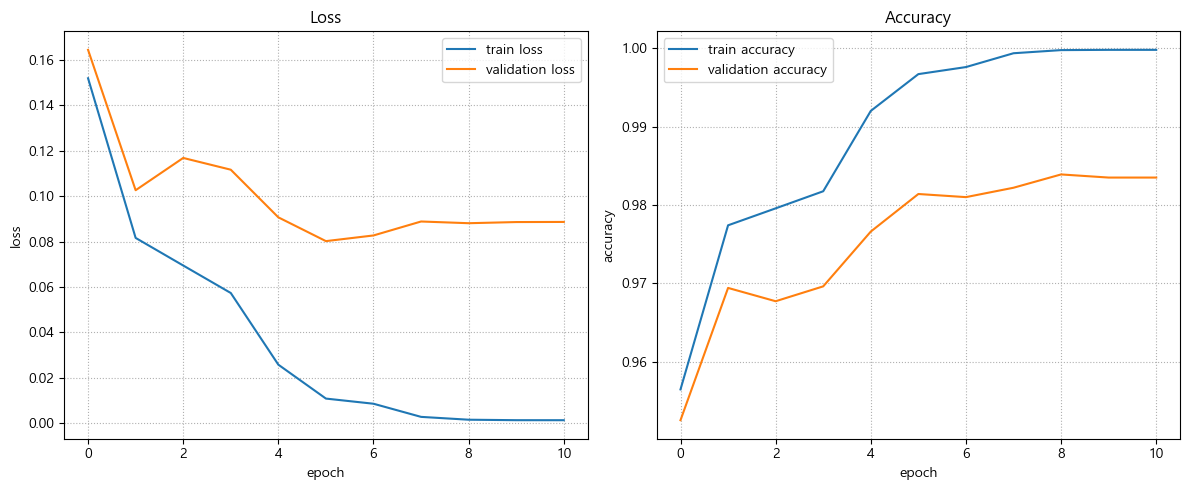

In [ ]:
# CosineAnnelingLR을 Big model에 적용시켜 시각화하기

import torch
import torch.nn as nn
from torchinfo import summary

from module.train import fit, train
from module.data import load_mnist_dataset
from module.utils import plot_fit_result

# ----------------------------
# 기본 설정
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
root_data_path = "datasets"
epochs = 300
batch_size = 256
lr = 0.001

# ----------------------------
# 데이터 로딩
# ----------------------------
train_loader = load_mnist_dataset(root_data_path, batch_size)
test_loader = load_mnist_dataset(root_data_path, batch_size, is_train=False)

# ----------------------------
# 모델 정의
# ----------------------------
class BigModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.ReLU())
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.out_block = nn.Linear(32, 10)

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        return self.out_block(X)

# ----------------------------
# 학습 설정
# ----------------------------
big_model = BigModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=lr)

# CosineAnnealingLR 스케줄러
ca_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10,
    eta_min=1e-6
)

# ----------------------------
# 학습
# ----------------------------
train_loss_list6, train_acc_list6, valid_loss_list6, valid_acc_list6 = fit(
    train_loader,
    test_loader,
    big_model,
    loss_fn,
    optimizer,
    epochs,
    save_best_model=False,
    patience=5,
    device=device,
    mode='multi',
    lr_scheduler=ca_scheduler
)

# ----------------------------
# 시각화
# ----------------------------
plot_fit_result(
    train_loss_list6,
    train_acc_list6,
    valid_loss_list6,
    valid_acc_list6
)


#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)
일정한 주기가 아닌, 변화의 주기를 늘린다.


In [70]:
optim = torch.optim.Adam(small_model.parameters(), lr=0.001)
cawr_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=10, # 변화주기(step/epoch)
    T_mult=2, # 새로운 변화주기(T_0) = 현재 T_0 * T_mult (한 주기가 끝날때마다 T_0를 다시 계산) 
    eta_min=1e-6 # 0.000001
)

In [71]:
lr_list = []
for epoch in range(epochs):
    
    for step in range(step_size):
        # 학습
        optim.step()
        optim.zero_grad()

    cawr_lr_scheduler.step()
    lr_list.append(cawr_lr_scheduler.get_last_lr())

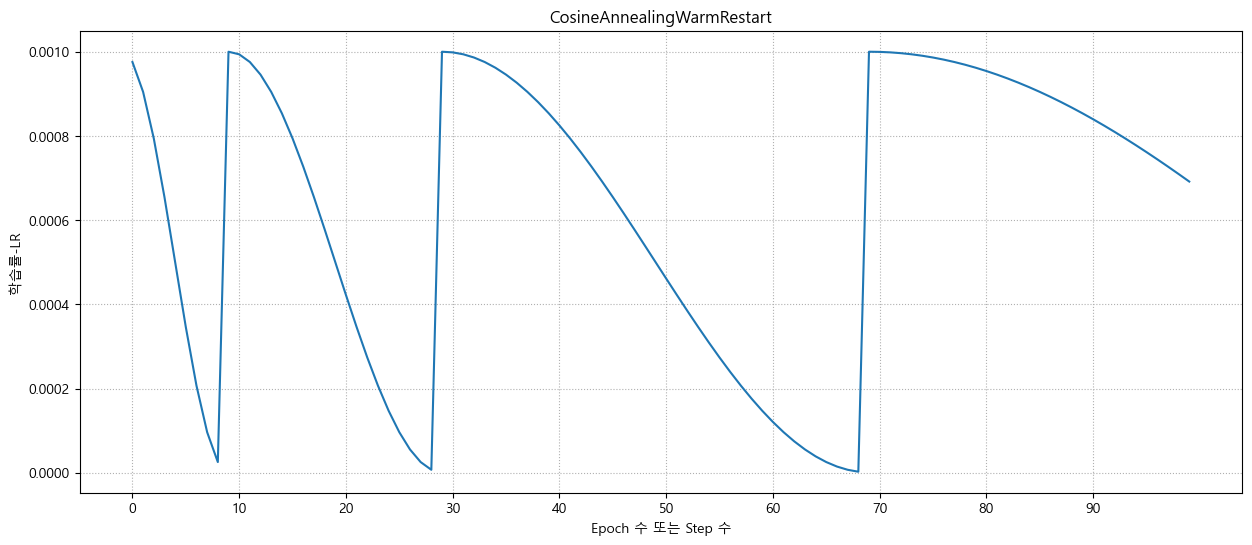

In [72]:
plot_lr("CosineAnnealingWarmRestart", lr_list)

>>>>>>Learning Rate가 0.001에서 0.0009755527298894294로 변경됨<<<<<<
Epoch[1/100] - Train loss: 0.14744 Train Accucracy: 0.95735 || Validation Loss: 0.14842 Validation Accuracy: 0.95480
>>>>>>Learning Rate가 0.0009755527298894294에서 0.0009046039886902864로 변경됨<<<<<<
Epoch[2/100] - Train loss: 0.07934 Train Accucracy: 0.97755 || Validation Loss: 0.09833 Validation Accuracy: 0.97030
>>>>>>Learning Rate가 0.0009046039886902864에서 0.0007940987335200904로 변경됨<<<<<<
Epoch[3/100] - Train loss: 0.05817 Train Accucracy: 0.98290 || Validation Loss: 0.08767 Validation Accuracy: 0.97260
>>>>>>Learning Rate가 0.0007940987335200904에서 0.0006548539886902864로 변경됨<<<<<<
Epoch[4/100] - Train loss: 0.03461 Train Accucracy: 0.98938 || Validation Loss: 0.07395 Validation Accuracy: 0.97730
>>>>>>Learning Rate가 0.0006548539886902864에서 0.0005005000000000001로 변경됨<<<<<<
Epoch[5/100] - Train loss: 0.02101 Train Accucracy: 0.99358 || Validation Loss: 0.07556 Validation Accuracy: 0.98000
>>>>>>Learning Rate가 0.000500500000000000

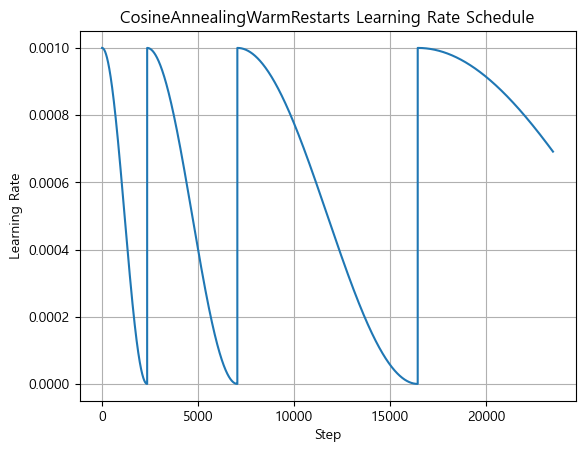

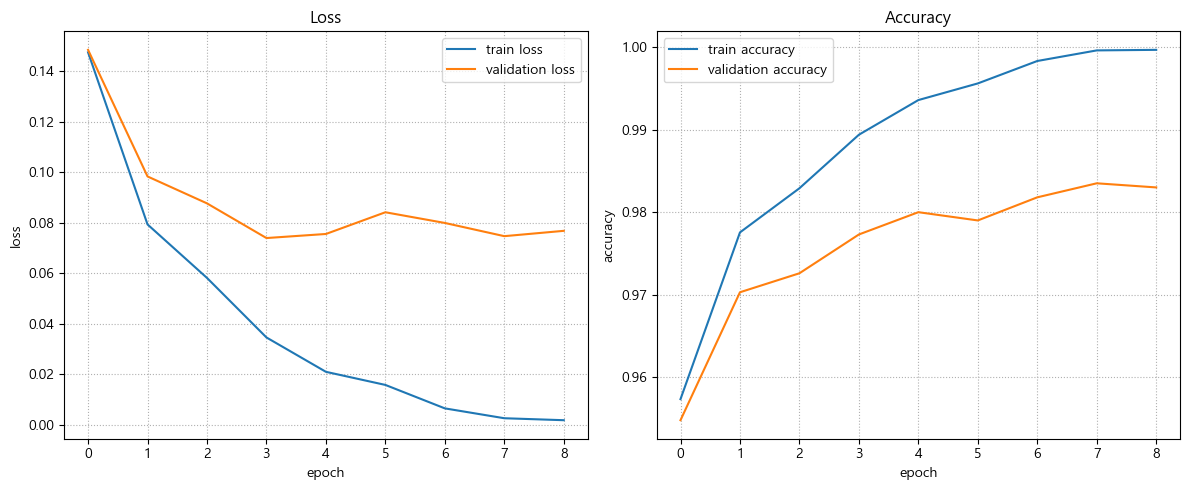

In [ ]:
# CosineAnnealingWarmRestart을 Big model에 적용시켜 시각화하기

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchinfo import summary

from module.train import fit_caws, train_caws
from module.data import load_mnist_dataset
from module.utils import plot_fit_result

# ----------------------------
# 기본 설정
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
root_data_path = "datasets"
epochs = 300
batch_size = 256
lr = 0.001

# ----------------------------
# 데이터 로딩
# ----------------------------
train_loader = load_mnist_dataset(root_data_path, batch_size)
test_loader = load_mnist_dataset(root_data_path, batch_size, is_train=False)

# ----------------------------
# 모델 정의
# ----------------------------
class BigModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.ReLU())
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.out_block = nn.Linear(32, 10)

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        return self.out_block(X)

# ----------------------------
# 학습 설정
# ----------------------------
big_model = BigModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=lr)

# CosineAnnealingWarmRestarts 스케줄러
cawr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

# ----------------------------
# 학습
# ----------------------------
train_loss_list7, train_acc_list7, valid_loss_list7, valid_acc_list7 = fit(
    train_loader,
    test_loader,
    big_model,
    loss_fn,
    optimizer,
    epochs,
    save_best_model=False,
    patience=5,
    device=device,
    mode='multi',
    lr_scheduler=cawr_scheduler
)

# ----------------------------
# 시각화용 Learning Rate 리스트 (별도 시뮬레이션)
# ----------------------------
steps_per_epoch = len(train_loader)
sim_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    torch.optim.Adam(big_model.parameters(), lr=lr),
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

lr_list = []
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        current_step = epoch + step / steps_per_epoch
        sim_scheduler.step(current_step)
        lr_list.append(sim_scheduler.get_last_lr()[0])

# 시각화
plt.plot(lr_list)
plt.title("CosineAnnealingWarmRestarts Learning Rate Schedule")
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()

# ----------------------------
# 학습 결과 시각화
# ----------------------------
plot_fit_result(
    train_loss_list7,
    train_acc_list7,
    valid_loss_list7,
    valid_acc_list7
)


## 학습률 스케줄러의 .step()을 언제 호출하느냐에 대한 설명

---

### ✅ 기본 전제: lr_scheduler.step()의 위치가 중요하다
PyTorch의 학습률 스케줄러는 학습률을 조절하기 위한 것으로, scheduler.step()을 호출하는 타이밍에 따라 다음과 같이 나뉩니다:

| 호출 위치        | 의미                                                               |
| ------------ | ---------------------------------------------------------------- |
| `epoch`마다 호출 | **에폭 단위로** 학습률을 변경함 (보통의 스케줄러에 적합)                               |
| `step`마다 호출  | **미니배치 단위로** 학습률을 변경함 (CosineAnnealingWarmRestarts처럼 고정 스케줄에 적합) |
---
### ✅ 지금 너가 사용하는 fit() 함수는?
```python
train_loss_listX, train_acc_listX, valid_loss_listX, valid_acc_listX = fit(..., lr_scheduler=스케줄러)
```

이렇게 사용하고 있으니, fit() 함수 내부에서 scheduler.step()이 epoch마다 실행되도록 짜여있다는 가정입니다:

#### 예시: fit 내부에 이런 구조일 것
```python
for epoch in range(epochs):
    for X, y in train_loader:
        # train step ...
        # optimizer.step()
        # optimizer.zero_grad()
        pass

    if lr_scheduler is not None:
        lr_scheduler.step()  # ← 이게 epoch 단위 호출

```

---

### ❗ 그런데 CosineAnnealingWarmRestarts는 다름
#### 예외: CosineAnnealingWarmRestarts는 step마다 호출해야 함
```python
for step in range(train_step_size):
    ...
    scheduler.step(step)  # ← 배치 단위 호출을 권장
```

PyTorch 공식 문서에 따르면 CosineAnnealingWarmRestarts는 내부적으로 step(epoch + batch_idx/num_batches)로 세분화해서 부드럽게 조절하길 원해요. 즉, epoch 단위로 step()을 하면 완전히 의도한 대로 동작하지 않습니다.

---

### ✅ 그래서 결론
| 상황                                 | fit 함수에 수정이 필요한가?                 |
| ---------------------------------- | --------------------------------- |
| `StepLR`, `CosineAnnealingLR` 사용 시 | ❌ 현재 epoch 단위로 호출되어도 OK           |
| `CosineAnnealingWarmRestarts` 사용 시 | ✅ `step`마다 호출되도록 `fit()` 내부 수정 필요 |